In [2]:
###### Diabetes type2
#### Date of study : 20190206
import warnings
warnings.filterwarnings("ignore")

In [3]:
# packages
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime 
from sklearn import preprocessing as prep
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [9]:
# import data
df=pd.read_csv("diabetes_dataset.csv",sep="\t")
print("Columns: ",list(df.columns))
df.head()

Columns:  ['ident', 'grossesse', 'allaitementoui', 'ageq3', 'alcool', 'kcalsac', 'aphyq3', 'ATCDfamdiabQ8', 'diab', 'dt_diab', 'encoupleq1', 'etude', 'FDEP99', 'FRAP_I_NC', 'gpsang_rhe', 'hypertensionq3', 'hypolipi2', 'ttailleq4', 'imcq4', 'lateralite', 'statmeno_q3_cl', 'pattern_western', 'pattern_prudent', 'poidsnaiss', 'PRAL', 'ageregle', 'sommeil', 'tabacq3', 'transitq4']


,ident,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,diab,dt_diab,...,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
0,100030,4,0,49.177276,11.88,1488.505569,19.5,0,0,NaN,...,0,0,-0.528209,-0.642924,3,2.688533,1,2,3,4
1,100035,4,0,44.804928,0.67,2115.009831,4.5,0,0,NaN,...,0,1,-0.533085,0.047411,1,-4.743413,1,2,3,1
2,100056,4,1,50.907598,3.62,2737.254258,10.5,0,0,NaN,...,0,0,0.651338,1.198105,1,-8.359993,2,3,3,1
3,100060,4,1,57.297741,0.00,2124.069913,13.5,1,0,NaN,...,0,1,-0.912994,1.228047,2,18.482343,1,2,3,1
4,100065,4,0,53.021218,21.07,1495.626383,21.0,0,1,01/01/1996,...,0,1,-0.698218,-0.904501,9,3.074301,1,2,3,1


In [10]:
print(df.describe())
print("each patient has one and only one diagnosis? :", len(identifiants.unique())==df.shape[0])

               ident     grossesse  allaitementoui         ageq3  \
count   72890.000000  72890.000000    72890.000000  72890.000000   
mean   440516.993182      3.483345        0.618960     52.896163   
std    152276.841424      1.305707        0.485646      6.672942   
min    100030.000000      1.000000        0.000000     41.793292   
25%    314293.500000      3.000000        0.000000     47.154004   
50%    441488.500000      4.000000        1.000000     51.718001   
75%    567666.750000      4.000000        1.000000     57.675565   
max    760068.000000      9.000000        1.000000     72.019165   

             alcool       kcalsac        aphyq3  ATCDfamdiabQ8          diab  \
count  72890.000000  72890.000000  72371.000000   72890.000000  72890.000000   
mean      11.636730   2139.739228     29.480639       0.110632      0.051928   
std       14.087916    601.607620     35.184340       0.313679      0.221882   
min        0.000000     11.172228      0.000000       0.000000     

In [11]:
# Deal with datetime columns 
df['diagnosis_day'] =(pd.to_datetime("2019-02-06")-pd.to_datetime(df['dt_diab'])).dt.days
df['diagnosis_day'].value_counts()

# REMOVE IDENT
identifiants=df.ident
df.drop(columns=["ident"],axis=1,inplace=True)

In [12]:
# Deal with NAN values
print('Percentage of nan values %')
nan_data = df[ df.columns[df.isna().any()].tolist()].isna().sum(axis=0)/df.shape[0]*100
print(nan_data)
data = df.loc[:,df.isna().sum(axis=0)/df.shape[0]*100<90]
data.head()               

Percentage of nan values %
aphyq3              0.712032
dt_diab            94.807244
etude               3.409247
FDEP99              5.760735
ttailleq4          14.007408
imcq4              11.911099
pattern_western     1.975580
pattern_prudent     1.975580
diagnosis_day      94.807244
dtype: float64


,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,diab,encoupleq1,etude,...,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
0,4,0,49.177276,11.88,1488.505569,19.5,0,0,1,13.0,...,0,0,-0.528209,-0.642924,3,2.688533,1,2,3,4
1,4,0,44.804928,0.67,2115.009831,4.5,0,0,1,NaN,...,0,1,-0.533085,0.047411,1,-4.743413,1,2,3,1
2,4,1,50.907598,3.62,2737.254258,10.5,0,0,1,13.0,...,0,0,0.651338,1.198105,1,-8.359993,2,3,3,1
3,4,1,57.297741,0.00,2124.069913,13.5,1,0,1,13.0,...,0,1,-0.912994,1.228047,2,18.482343,1,2,3,1
4,4,0,53.021218,21.07,1495.626383,21.0,0,1,1,13.0,...,0,1,-0.698218,-0.904501,9,3.074301,1,2,3,1


<Figure size 360x144 with 0 Axes>

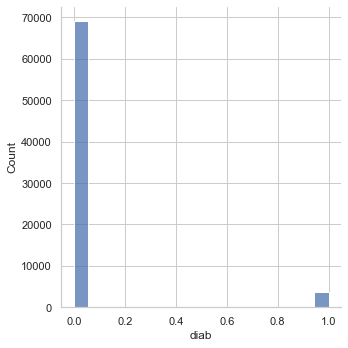

In [13]:
# First analysis: Output distribution
fig= plt.figure(figsize=(5, 2))
sns.displot(data, x="diab")
plt.show()

we have a very unbalanced data so we have to keep that in mind for the training process 

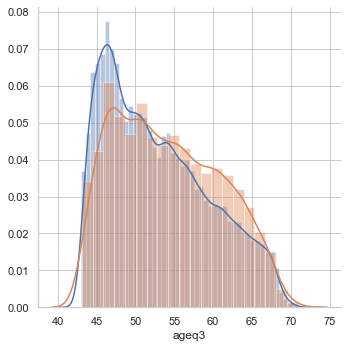

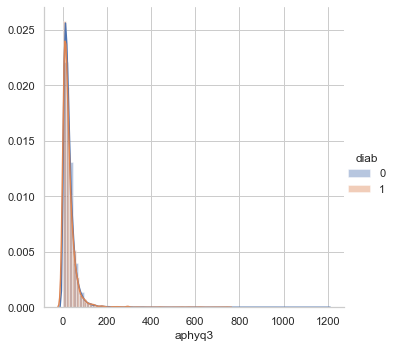

In [14]:
# Age and BMI DISTRIBUTION

sns.FacetGrid(data,hue="diab",size=5).map(sns.distplot,"ageq3")
sns.FacetGrid(data,hue="diab",size=5).map(sns.distplot,"aphyq3").add_legend()





<AxesSubplot:xlabel='diab', ylabel='ageq3'>

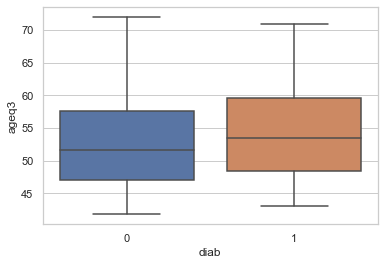

In [391]:
sns.boxplot(data=data,y="ageq3",x="diab")

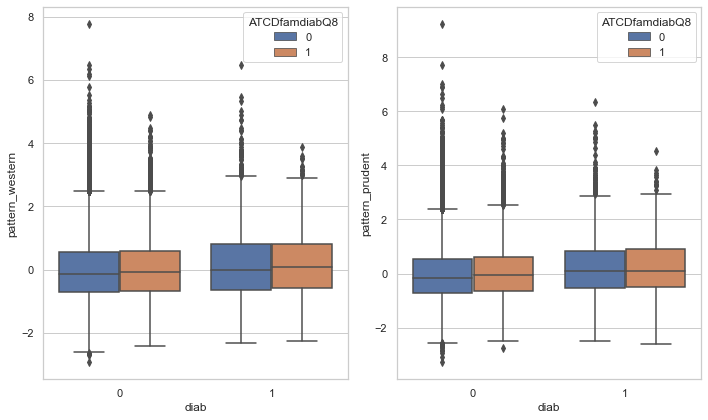

In [392]:
# Type of diet impact when there is a history in the family
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.boxplot(data=data,y="pattern_western",x="diab",hue='ATCDfamdiabQ8',ax=axes[0])
sns.boxplot(data=data,y="pattern_prudent",x="diab",hue='ATCDfamdiabQ8',ax=axes[1])
fig.tight_layout()



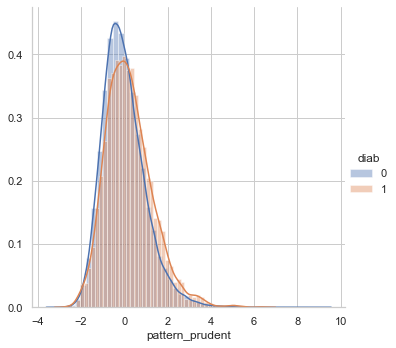

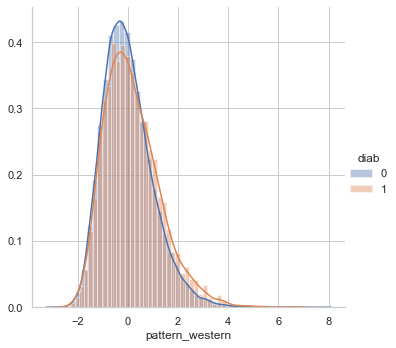

In [393]:
sns.FacetGrid(data,hue="diab",size=5).map(sns.distplot,"pattern_prudent").add_legend()
sns.FacetGrid(data,hue="diab",size=5).map(sns.distplot,"pattern_western").add_legend()

In [15]:
# Deal with colinearity:
corr= data.corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,grossesse,allaitementoui,ageq3,alcool,kcalsac,aphyq3,ATCDfamdiabQ8,diab,encoupleq1,etude,FDEP99,FRAP_I_NC,gpsang_rhe,hypertensionq3,hypolipi2,ttailleq4,imcq4,lateralite,statmeno_q3_cl,pattern_western,pattern_prudent,poidsnaiss,PRAL,ageregle,sommeil,tabacq3,transitq4
grossesse,1.00,0.43,-0.01,-0.02,0.05,-0.01,-0.00,0.01,0.03,-0.05,0.00,0.01,-0.04,-0.01,0.06,0.04,0.04,-0.01,0.01,0.05,0.00,-0.01,0.01,-0.00,0.00,0.03,0.05
allaitementoui,0.43,1.00,-0.01,-0.01,0.05,0.00,-0.00,-0.01,0.01,0.00,-0.02,0.02,-0.02,-0.01,0.03,0.00,0.02,-0.01,-0.01,0.02,0.02,-0.02,-0.01,0.00,-0.01,0.01,0.02
ageq3,-0.01,-0.01,1.00,-0.01,-0.10,0.03,-0.07,0.04,0.02,-0.13,-0.01,-0.02,0.06,0.20,0.00,0.19,0.13,0.08,0.44,-0.22,0.03,0.06,-0.13,0.03,0.08,0.10,-0.01
alcool,-0.02,-0.01,-0.01,1.00,0.12,0.04,-0.00,0.01,0.00,0.08,-0.04,0.50,-0.01,0.01,0.02,0.07,0.03,0.02,-0.00,0.36,0.06,0.00,0.02,0.01,0.01,-0.14,0.02
kcalsac,0.05,0.05,-0.10,0.12,1.00,0.02,0.01,0.01,0.00,-0.01,0.02,0.47,-0.02,0.01,-0.01,0.06,0.05,-0.02,-0.05,0.66,0.26,-0.03,0.22,0.01,-0.01,0.02,-0.01
aphyq3,-0.01,0.00,0.03,0.04,0.02,1.00,-0.01,-0.01,-0.00,0.01,-0.03,0.07,-0.01,-0.02,-0.00,-0.05,-0.05,-0.00,0.02,-0.02,0.09,-0.01,-0.05,0.01,-0.00,-0.01,-0.01
ATCDfamdiabQ8,-0.00,-0.00,-0.07,-0.00,0.01,-0.01,1.00,0.08,-0.00,-0.01,0.01,-0.01,-0.00,0.00,-0.02,0.04,0.05,-0.15,-0.06,0.02,0.03,-0.06,0.01,-0.01,-0.14,-0.00,-0.02
diab,0.01,-0.01,0.04,0.01,0.01,-0.01,0.08,1.00,0.01,-0.04,0.02,-0.01,0.01,0.09,0.02,0.26,0.25,0.02,0.02,0.04,0.05,0.01,0.03,-0.01,0.03,-0.00,0.02
encoupleq1,0.03,0.01,0.02,0.00,0.00,-0.00,-0.00,0.01,1.00,-0.05,0.01,-0.00,0.10,0.00,0.01,0.01,0.02,0.01,0.01,-0.00,0.01,-0.00,-0.00,0.03,0.01,0.01,0.01
etude,-0.05,0.00,-0.13,0.08,-0.01,0.01,-0.01,-0.04,-0.05,1.00,-0.23,0.11,-0.02,-0.09,0.00,-0.13,-0.12,-0.04,-0.06,-0.02,0.02,-0.03,0.03,-0.03,-0.05,-0.11,-0.01


In [16]:
### let's delete hypolipi2 sommeil kcalsac
data.drop(columns=["hypolipi2","sommeil", "kcalsac"],inplace=True)

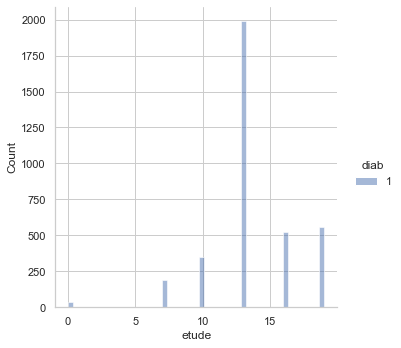

In [17]:
# transform étude
sns.displot(data[data.diab==1], x="etude", hue="diab")
data['etude'] = pd.cut(data['etude'],3, labels=[1,2,3])
data['etude'] = data['etude'].astype("float")

In [18]:
# Find NUMERICAL and ORIDINAL/CATEGORICAL columns
cat_ord_cols = list(data.columns[data.nunique()<=9])
#cat_ord_cols.remove("etude")
cat_ord_cols.remove("diab")
num_cols = list(data.columns[data.nunique()>9])+["etude"]
## 
for col in data.columns:
    if col in cat_ord_cols :
        data[col].fillna(9,inplace=True)
    if col in num_cols :
        data[col].fillna(data[col].median(),inplace=True)
        

In [19]:
# One hot encode 
cat_cols = list(data.columns[data.nunique()<=3])
cat_cols.remove("diab")

for col in cat_cols:
    one_hot = pd.get_dummies(data[col],prefix=col)
    # Drop column B as it is now encoded
    data = data.drop(col,axis = 1)
    # Join the encoded df
    data = data.join(one_hot)

In [20]:
data.head()

,grossesse,ageq3,alcool,aphyq3,diab,etude,FDEP99,FRAP_I_NC,gpsang_rhe,ttailleq4,...,ATCDfamdiabQ8_0,ATCDfamdiabQ8_1,encoupleq1_0,encoupleq1_1,encoupleq1_9,hypertensionq3_0,hypertensionq3_1,lateralite_0,lateralite_1,lateralite_9
0,4,49.177276,11.88,19.5,0,3.0,0.019187,8.455401,4,79.0,...,1,0,0,1,0,1,0,1,0,0
1,4,44.804928,0.67,4.5,0,9.0,0.548716,8.113449,1,76.0,...,1,0,0,1,0,1,0,1,0,0
2,4,50.907598,3.62,10.5,0,3.0,0.236704,10.547431,4,73.0,...,1,0,0,1,0,1,0,1,0,0
3,4,57.297741,0.00,13.5,0,3.0,0.455917,13.310274,1,86.0,...,0,1,0,1,0,0,1,1,0,0
4,4,53.021218,21.07,21.0,1,3.0,0.561010,13.632363,1,86.0,...,1,0,0,1,0,0,1,1,0,0


In [41]:
# Train and test 
X_app,X_test,y_app,y_test = train_test_split(data.drop(columns=["diab"]), data['diab'],stratify=data['diab'], test_size=0.20,random_state=1)
print(y_app.value_counts())
print(y_test.value_counts())


0    55284
1     3028
Name: diab, dtype: int64
0    13821
1      757
Name: diab, dtype: int64


In [33]:
# REG
scaler= prep.StandardScaler()
# Fit on train and apply it
X_train = scaler.fit_transform(X_app,y_train)
# Apply on test 
X_test = scaler.fit_transform(X_test)

In [34]:
# First baseline model 
LR = LogisticRegression()
LR.fit(X_train,y_train)
# Predict 
predictions = LR.predict(X_test)
# Use score method to get accuracy of model
score = LR.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))

Model's accuracy : 0.9488269995884209
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13821
           1       0.58      0.05      0.10       757

    accuracy                           0.95     14578
   macro avg       0.77      0.53      0.54     14578
weighted avg       0.93      0.95      0.93     14578



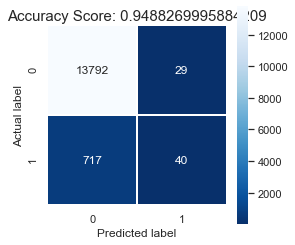

In [35]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Ensemble methods:
      ## Bagging: Random forest
      ## Bosting: XGBOOST
    

In [36]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
# Predict 
predictions = RF.predict(X_test)
# Use score method to get accuracy of model
score = RF.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))

Model's accuracy : 0.9484154204966387
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13821
           1       0.59      0.02      0.04       757

    accuracy                           0.95     14578
   macro avg       0.77      0.51      0.51     14578
weighted avg       0.93      0.95      0.93     14578



In [37]:
XG = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XG.fit(X_train,y_train)
# Predict 
predictions = XG.predict(X_test)
# Use score method to get accuracy of model
score = XG.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))

Model's accuracy : 0.9475236657977775
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13821
           1       0.45      0.05      0.09       757

    accuracy                           0.95     14578
   macro avg       0.70      0.52      0.53     14578
weighted avg       0.92      0.95      0.93     14578



# Undersampling


In [42]:
# Undersample
# Create an undersampler object
rus = RandomUnderSampler()
X_train, y_train= rus.fit_resample(X_app, y_app)
y_train.value_counts()

from imblearn.over_sampling import SMOTE

### oversample :
sm = SMOTE()
X_train, y_train=sm.fit_resample(X_app, y_app)
y_train.value_counts()

1    55284
0    55284
Name: diab, dtype: int64

In [40]:
X_app

,grossesse,ageq3,alcool,aphyq3,etude,FDEP99,FRAP_I_NC,gpsang_rhe,ttailleq4,imcq4,...,ATCDfamdiabQ8_0,ATCDfamdiabQ8_1,encoupleq1_0,encoupleq1_1,encoupleq1_9,hypertensionq3_0,hypertensionq3_1,lateralite_0,lateralite_1,lateralite_9
6234,2,51.164956,7.98,6.0,3.0,0.197371,13.968389,4,74.0,21.30,...,1,0,0,1,0,1,0,1,0,0
22534,4,65.771389,28.93,10.5,3.0,1.484846,8.623653,4,84.0,24.17,...,1,0,0,1,0,0,1,1,0,0
72743,4,56.024641,24.10,42.0,3.0,0.635628,14.189002,1,74.0,19.53,...,1,0,0,1,0,1,0,1,0,0
64108,4,44.435318,19.88,22.5,3.0,0.236384,14.412255,4,67.0,21.88,...,1,0,0,1,0,0,1,0,0,1
36572,4,53.029432,11.95,12.0,3.0,0.244111,10.103692,2,76.0,20.20,...,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29587,5,57.913758,31.35,9.0,3.0,0.607443,18.965203,1,73.0,19.97,...,1,0,0,1,0,0,1,1,0,0
65819,3,57.234771,11.35,15.0,3.0,-0.906296,10.616146,9,82.0,28.13,...,0,1,0,1,0,1,0,0,1,0
48184,1,55.646817,11.58,24.0,3.0,-0.757133,11.609597,9,76.0,23.14,...,1,0,1,0,0,1,0,0,0,1
17791,2,45.467488,7.42,15.0,3.0,-0.415021,20.057975,1,77.0,22.94,...,1,0,0,1,0,1,0,1,0,0


Model's accuracy : 0.8867471532446152
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     13821
           1       0.17      0.31      0.22       757

    accuracy                           0.89     14578
   macro avg       0.57      0.61      0.58     14578
weighted avg       0.92      0.89      0.90     14578



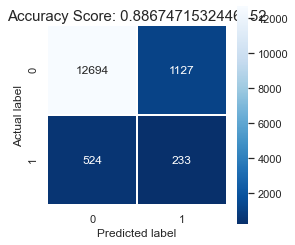

In [43]:
# First baseline model 
LR = LogisticRegression()
LR.fit(X_train,y_train)
# Predict 
predictions = LR.predict(X_test)
# Use score method to get accuracy of model
score = LR.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_features=auto, n_estimators=200.........................
[CV 1/5; 1/6] END max_features=auto, n_estimators=200;, score=0.873 total time=  24.3s
[CV 2/5; 1/6] START max_features=auto, n_estimators=200.........................
[CV 2/5; 1/6] END max_features=auto, n_estimators=200;, score=0.993 total time=  23.3s
[CV 3/5; 1/6] START max_features=auto, n_estimators=200.........................
[CV 3/5; 1/6] END max_features=auto, n_estimators=200;, score=0.994 total time=  19.5s
[CV 4/5; 1/6] START max_features=auto, n_estimators=200.........................
[CV 4/5; 1/6] END max_features=auto, n_estimators=200;, score=0.993 total time=  24.6s
[CV 5/5; 1/6] START max_features=auto, n_estimators=200.........................
[CV 5/5; 1/6] END max_features=auto, n_estimators=200;, score=0.994 total time=  24.3s
[CV 1/5; 2/6] START max_features=auto, n_estimators=700.........................
[CV 1/5; 2/6] END m

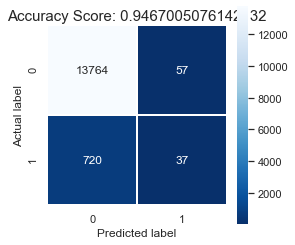

In [44]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

RF = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,verbose =100 )
RF.fit(X_train,y_train)

# Predict 
predictions = RF.predict(X_test)
# Use score method to get accuracy of model
score = RF.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Model's accuracy : 0.6869255041843875
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     13821
           1       0.11      0.67      0.18       757

    accuracy                           0.69     14578
   macro avg       0.54      0.68      0.49     14578
weighted avg       0.93      0.69      0.77     14578



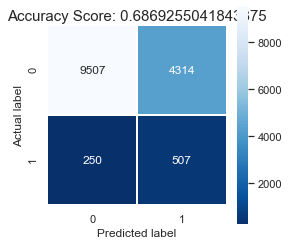

In [427]:
XG = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XG.fit(X_train,y_train)
# Predict 
predictions = XG.predict(X_test)
# Use score method to get accuracy of model
score = XG.score(X_test, y_test)
print("Model's accuracy :",score)
cm = metrics.confusion_matrix(y_test, predictions)
print(metrics.classification_report(y_test, predictions))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);